In [12]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(".."))

from scripts.simulation import ar, rossler
from scripts.utils import phase, surrogates

In [13]:
t_sin, SIN = np.arange(1000), np.sin(np.arange(1000)*0.01)
t_ros, ROS = rossler.simulate(wx=1, start=200, seed=1)
t_ar, AR = ar.simulate(phi=[0.9], seed=1)
print(SIN.shape, ROS.shape, AR.shape)

(1000,) (1000, 6) (1000, 1)


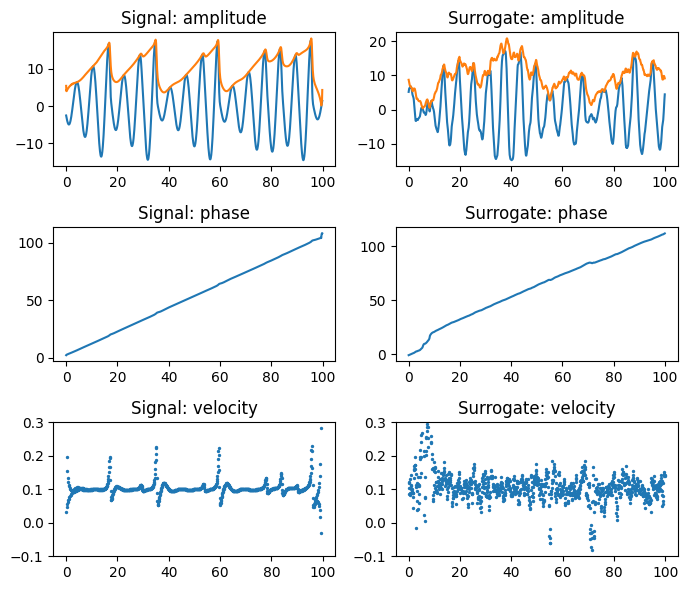

In [14]:
t = t_ros
x = ROS[:,0]
y = surrogates.IAAFT(x)[:,0]

analytical_x = hilbert(x)
analytical_y = hilbert(y)
amplitude_x = np.abs(analytical_x)
amplitude_y = np.abs(analytical_y)
phase_x = np.unwrap(np.angle(analytical_x))
phase_y = np.unwrap(np.angle(analytical_y))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,6))

axs[0,0].plot(t, x)
axs[0,1].plot(t, y)

axs[0,0].plot(t, amplitude_x)
axs[0,1].plot(t, amplitude_y)

axs[0,0].set_title("Signal: amplitude")
axs[0,1].set_title("Surrogate: amplitude")

axs[1,0].plot(t, phase_x)
axs[1,1].plot(t, phase_y)

axs[1,0].set_title("Signal: phase")
axs[1,1].set_title("Surrogate: phase")

axs[2,0].scatter(t[:-1], np.diff(phase_x), s=2)
axs[2,0].set_ylim([-0.1, 0.3])
axs[2,1].scatter(t[:-1], np.diff(phase_y), s=2)
axs[2,1].set_ylim([-0.1, 0.3])

axs[2,0].set_title("Signal: velocity")
axs[2,1].set_title("Surrogate: velocity")

plt.tight_layout()
plt.show()

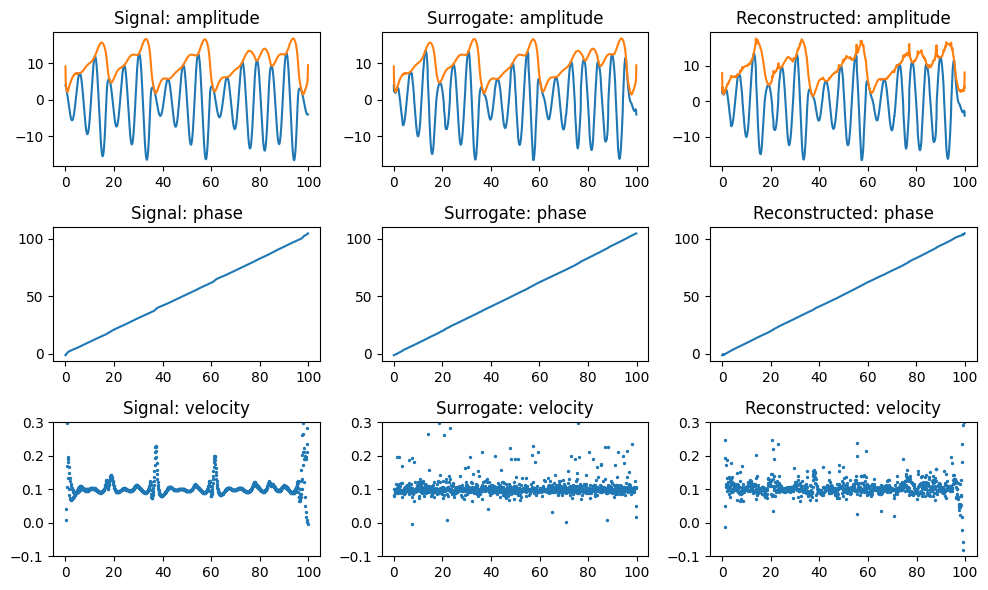

In [15]:
t = t_ros
x = ROS[:,1]
y, phase_x, phase_y, amplitude_x = surrogates.hilbert_velocity_randomized(x, return_hilbert=True)

# For verification purposes
analytical_z = hilbert(y)
amplitude_z = np.abs(analytical_z)
phase_z = np.unwrap(np.angle(analytical_z))
z = amplitude_z * np.cos(phase_z)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,6))

axs[0,0].plot(t, x)
axs[0,1].plot(t, y)
axs[0,2].plot(t, z)

axs[0,0].plot(t, amplitude_x)
axs[0,1].plot(t, amplitude_x)
axs[0,2].plot(t, amplitude_z)

axs[0,0].set_title("Signal: amplitude")
axs[0,1].set_title("Surrogate: amplitude")
axs[0,2].set_title("Reconstructed: amplitude")

axs[1,0].plot(t, phase_x)
axs[1,1].plot(t, phase_y)
axs[1,2].plot(t, phase_z)

axs[1,0].set_title("Signal: phase")
axs[1,1].set_title("Surrogate: phase")
axs[1,2].set_title("Reconstructed: phase")

axs[2,0].scatter(t[:-1], np.diff(phase_x), s=2)
axs[2,0].set_ylim([-0.1, 0.3])
axs[2,1].scatter(t[:-1], np.diff(phase_y), s=2)
axs[2,1].set_ylim([-0.1, 0.3])
axs[2,2].scatter(t[:-1], np.diff(phase_z), s=2)
axs[2,2].set_ylim([-0.1, 0.3])

axs[2,0].set_title("Signal: velocity")
axs[2,1].set_title("Surrogate: velocity")
axs[2,2].set_title("Reconstructed: velocity")

plt.tight_layout()
plt.show()

In [16]:
n_tests = 100
n_surrogates = 19
surrogate_type = "PhaseVel"

MPC_origs = np.zeros(n_tests)
MPC_surrogates = np.zeros((n_tests, n_surrogates))

eyx = 1
exy = 1
sigma = 0


for test in range(n_tests):
    _, ROS = rossler.simulate(eyx=eyx, exy=exy, sigma=sigma)
    x, y = ROS[0,:], ROS[3,:]
    phase_x = np.unwrap(np.angle(hilbert(x)))
    phase_y = np.unwrap(np.angle(hilbert(y)))

    MPC_origs[test] = phase.MPC(phase_x, phase_y)

    if surrogate_type == "IAFFT":
        x_sur, y_sur = surrogates.bivariate_IAAFT(x, y, N=n_surrogates)
        phase_x_sur = np.unwrap(np.angle(hilbert(x_sur, axis=0)), axis=0)
        phase_y_sur = np.unwrap(np.angle(hilbert(y_sur, axis=0)), axis=0)
        for surrogate in range(n_surrogates):
            MPC_surrogates[test, surrogate] = phase.MPC(phase_x_sur[:, surrogate], phase_y_sur[:, surrogate])
    
    elif surrogate_type == "PhaseVel":
        for surrogate in range(n_surrogates):
            phase_x_sur = surrogates.randomize_phase_velocity(phase_x)
            phase_y_sur = surrogates.randomize_phase_velocity(phase_y)

            MPC_surrogates[test, surrogate] = phase.MPC(phase_x_sur, phase_y_sur)

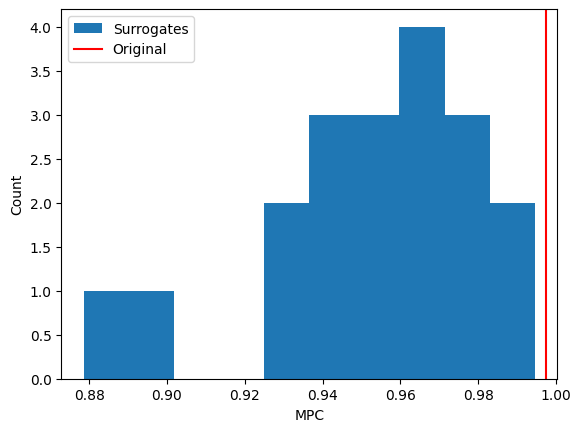

In [17]:
test_to_plot = 9
plt.figure()
plt.hist(MPC_surrogates[test_to_plot,:], label="Surrogates")
plt.axvline(MPC_origs[test_to_plot], c='r', label="Original")
plt.xlabel("MPC")
plt.ylabel("Count")
plt.legend()
plt.show()

In [18]:
print("R_orig mean, std:", np.mean(MPC_origs), np.std(MPC_origs))
print("R_surr mean (per test):", np.mean(MPC_surrogates, axis=1).mean(),
      "std of per-test surrogate means:", np.std(np.mean(MPC_surrogates, axis=1)))
print("R_surr max mean:", np.mean(np.max(MPC_surrogates, axis=1)))
print("Histogram of R_orig vs max(surr):")
diffs = MPC_origs - np.max(MPC_surrogates, axis=1)
print("mean diff:", diffs.mean(), "median diff:", np.median(diffs))
print("how many R_orig > max(surr) (sanity):", np.sum(diffs>0))

R_orig mean, std: 0.9969021881549068 0.0012426503446844686
R_surr mean (per test): 0.9054288334756693 std of per-test surrogate means: 0.09344472707278925
R_surr max mean: 0.9880682924447811
Histogram of R_orig vs max(surr):
mean diff: 0.008833895710125599 median diff: 0.0019210276097197942
how many R_orig > max(surr) (sanity): 94
